In [1]:
import pandas as pd
import glob
import numpy as np
from itertools import chain
import math
import matplotlib.pyplot as plt 
import os
import cv2
from moviepy.editor import VideoFileClip
import copy
import skvideo.io
import itertools
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
def get_fps(videoname):
    clip = VideoFileClip(videoname)
    return clip.fps

def get_duration(videoname):
    clip = VideoFileClip(videoname)
    return clip.duration

def get_skel(df):
    allparts = np.arange(0,18)
    confidence_threshold = .6
    df = df.reset_index()
    p = df.loc[0,:].peaks
    parts = list(chain.from_iterable(p))
    df_part = pd.DataFrame(parts,columns = ['x', 'y','c', 'idx'])
    
    if len(df.limbs_subset[0])>0:
        subset = df.limbs_subset[0][0][:-2]
    else:
        subset = []
    idx_in_row = [[i]*len(row) for i, row in enumerate(p)] 
    part_idx = list(chain.from_iterable([[i for j in part] for i, part in enumerate(idx_in_row)]))
    # add person index
    

    df_part['part_idx'] = part_idx
    df_part['in_skel'] = np.nan
    df_part.loc[np.isin(df_part.idx,subset),'in_skel'] = 1
    df_part.loc[~np.isin(df_part.idx,subset),'in_skel'] = 0
    
    df_part['include'] = df_part['in_skel']
    
    # if parts missing from skeleton add the most confident part not included in skeleton if over threshold
    if len(subset)>0:
        parts_missing_from_skel = np.where(subset==-1)[0] #allparts[~np.isin(allparts,subset)] # parts missing from skeleton
    else:
        parts_missing_from_skel = allparts
    extra_skel_parts = np.asarray(df_part.loc[df_part.in_skel==0,'part_idx']) # fitted parts outside skel
    parts2add = parts_missing_from_skel[np.isin(parts_missing_from_skel,extra_skel_parts)] # add these parts
    df_part_extra = df_part[np.isin(df_part.part_idx, parts2add)]
    df_part_extra = df_part_extra[df_part_extra.c > confidence_threshold]
    idx = df_part_extra.groupby('part_idx')['c'].transform(max) == df_part_extra['c']
    idx = np.asarray(df_part_extra[idx].idx)
    df_part.loc[np.isin(df_part.idx,idx),'include'] = 1 
    return df_part


def get_displacement(df, inp, outp): # different from other deltas - need shortest path
    angle = df[inp]
    angle_fill = angle.fillna(method='ffill')
    angle_fill.loc[angle_fill<0] = angle_fill.loc[angle_fill<0]+360
    angle_fill = np.asarray(angle_fill)
    a = angular_disp(angle_fill[0:len(angle_fill)-1], angle_fill[1:len(angle_fill)])
    df[outp] = np.concatenate((np.asarray([0]),a))
    return df

def get_delta(df, inp, outp):
    x = df[inp]
    x_fill = x.fillna(method='ffill')
    delta = np.concatenate((np.asarray([0]),np.diff(x_fill)))*(np.asarray(x*0)+1)
    df[outp] = delta
    return df

def add_missing_frames(df):
    all_frames = np.arange(df.frame.max()+1)
    missing_frames = all_frames[~np.isin(all_frames, df.frame.unique())]
    if len(missing_frames)>0:
        print('missing frames')
        print(df.video.unique()[0])
        row_add = df.iloc[[0,1],:]
        row_add[['x','y','c']] = np.nan
        row_add = row_add.append([row_add]*int(np.ceil(len(missing_frames)/2)), ignore_index=True)
        row_add = row_add.loc[:len(missing_frames)-1]
        row_add['frame'] = missing_frames
        df = df.append(row_add)
    return df

def add_missing_parts(df): # add rows of nans for missing parts, helps for interpolation, need frame column
    allparts = np.arange(0,18)
    missing_parts = allparts[~np.isin(allparts,df.part_idx.unique())]
    a = np.empty((len(missing_parts),len(df.columns))) # rows, cols
    if len(a)>0:
        a[:] = np.nan
        missing_df = pd.DataFrame(a, columns=df.columns)
        missing_df['part_idx'] = missing_parts
    else:
        missing_df = pd.DataFrame()
    df = df.append(missing_df)
    df = df.drop(['video', 'frame'],axis=1)
    return df

def interp(df, inp, outp):
    df[outp] = df[inp].interpolate()
    return df

def rem_outliers1(df, inp, outp): 
    # removes the point before the outlier (outliers are removed using displacement)
    # make sure first element is not outlier
    angle = copy.deepcopy(df[inp])
    mean_a = np.mean(angle); std_a = np.nanstd(angle);
    idx = np.asarray(np.abs((angle-mean_a))>2*std_a)
    angle[idx] = np.nan
    angle[np.asarray(list(idx[1:])+[False])] = np.nan
    df[outp] = angle
    return df

def get_frame_dim(video):
    videogen = skvideo.io.vreader(video)
    new_videogen = itertools.islice(videogen, 0, 1, 1)
    for image in new_videogen:
        a = 1
    return image

def get_one_frame(video,f1):
    videogen = skvideo.io.vreader(video)
    new_videogen = itertools.islice(videogen, f1, f1+1, 1)
    for image in new_videogen:
        a = 1
    return image

def count_missing_frames(df):
    return pd.Series({'nframe':np.sum(df.sort_values('frame')['frame'].diff().iloc[1:]!=1)})

def count_nans(df):
    return pd.Series({'nnan':np.sum(df['x_vid'].isnull())})


In [3]:
#################################
# load video/pkl and extract kps
#################################

# path for pkl and input video files here
path = '../input_data'

file = 'infant_example.mov'

videofiles = [os.path.join(path,file)]


bps = ["Nose","Neck","RShoulder","RElbow","RWrist","LShoulder","LElbow","LWrist","RHip","RKnee","RAnkle","LHip","LKnee",\
 "LAnkle","REye","LEye","REar","LEar"]

joints = [['RShoulder','Neck', 'RElbow'],\
['RElbow', 'RShoulder','RWrist'],\
['RHip','LHip', 'RKnee'],\
['RKnee', 'RHip','RAnkle'],\
['LShoulder','Neck', 'LElbow'],\
['LElbow', 'LShoulder','LWrist'],\
['LHip','RHip', 'LKnee'],\
['LKnee', 'LHip','LAnkle']]

print('loading video information...')

# get fps and screen dim
df_fps = pd.DataFrame()
fpsl = []; durl = [];
rowlist = []; collist = []

for ivideo in videofiles:
    print(ivideo)
    if os.path.basename(ivideo)[-3:]=='avi':
        fps = 30
    else:
        fps = get_fps(ivideo)
    duration = get_duration(ivideo)
    fpsl.append(fps)
    durl.append(duration)
    img = get_frame_dim(ivideo)
    nrows = len(img)
    ncols = len(img[0])
    rowlist.append(nrows); collist.append(ncols);

df_fps['duration'] = pd.Series(durl)
df_fps['fps'] = pd.Series(fpsl)
df_fps['pixel_x'] = pd.Series(collist)
df_fps['pixel_y'] = pd.Series(rowlist)
df_fps['video'] = [os.path.basename(i)[:-4] for i in videofiles]

print('loading keypoints...')
files = [ivid[:-4]+'.pkl' for ivid in videofiles]
files = files
df_pkl = pd.DataFrame()
for file in files:
    one_file = pd.read_pickle(file).reset_index().drop('index',axis = 1)
    df_pkl = df_pkl.append(one_file)
df_pkl = df_pkl.reset_index().drop('index', axis = 1)
df = df_pkl.groupby(['frame','video']).apply(lambda x:get_skel(x)).reset_index().drop('level_2',axis = 1)

df

loading video information...
../input_data/infant_example.mov
loading keypoints...


,frame,video,x,y,c,idx,part_idx,in_skel,include
0,0,infant_example,283,223,0.940481,0,0.0,1.0,1.0
1,0,infant_example,279,342,0.823882,1,1.0,1.0,1.0
2,0,infant_example,192,340,0.756054,2,2.0,1.0,1.0
3,0,infant_example,102,390,0.847020,3,3.0,1.0,1.0
4,0,infant_example,58,316,0.855769,4,4.0,1.0,1.0
5,0,infant_example,236,901,0.286396,5,4.0,0.0,0.0
6,0,infant_example,367,345,0.756355,6,5.0,1.0,1.0
7,0,infant_example,438,408,0.845520,7,6.0,1.0,1.0
8,0,infant_example,470,330,0.863947,8,7.0,1.0,1.0
9,0,infant_example,238,606,0.500839,9,8.0,1.0,1.0


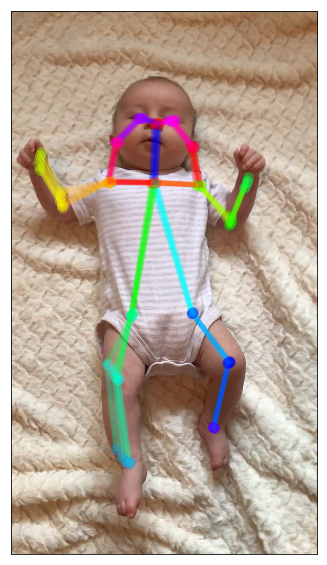

In [6]:
######################################################
# Plotting functions and variables
######################################################

def plot_skel(df, vid, frame,ax,xvar,yvar):
    alpha =.3
    df = df[(df.video==vid)&(df.frame==frame)].reset_index(drop=True)
    for i,limb in enumerate(limbSeq):
        l1 = limb[0]-1; l2 = limb[1]-1;
        if (len(df[df.part_idx==l1])>0) & (len(df[df.part_idx==l2])>0):
            ax.plot([df[df.part_idx==l1][xvar].iloc[0],df[df.part_idx==l2][xvar].iloc[0]], [df[df.part_idx==l1][yvar].iloc[0],df[df.part_idx==l2][yvar].iloc[0]],linewidth=5, color=[j/255 for j in colors[i]], alpha=alpha)
    # plot kp
    for i in range(len(df)):
        ax.plot(df[xvar][i],df[yvar][i], 'o',markersize = 10, color=[j/255 for j in colors[i]], alpha=alpha)

def gen_one_frame(df, vid, frame,dpi):
    fig=plt.figure(dpi=dpi)
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    
    plot_skel(df, vid, i, ax, 'x', 'y')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2)
    ax.invert_yaxis()
    ax.axis('off')
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    im = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
    im = im.reshape(int(height), int(width), 3)
    plt.close()
    return im

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18], [3, 17], [6, 18]]

################################
# Plot frames of one video
################################


vid = 'infant_example'
vidpath = os.path.join(path,vid+'.mov')
frame1 = 0
framen = 5
frame_interval = 1
xvar = 'x'
yvar = 'y'

df1 = df[df.include==1]

fig,ax=plt.subplots(nrows=1,ncols=1, figsize=(10,10))
img = get_one_frame(vidpath,0)
ax.imshow(img)
for i in np.arange(frame1,framen,frame_interval):
    plot_skel(df1[df1.frame==i], vid, i, ax, xvar,yvar)

ax.set_aspect('equal', adjustable='box')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

fig.savefig(os.path.join(path,'pose_infant.png'))